<a href="https://colab.research.google.com/github/pedrogasg/manning-rl-liveproject/blob/master/self-driving-vehicles/deliverable_milestone_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get update  > /dev/null 2>&1
!apt-get install -y xvfb x11-utils > /dev/null 2>&1
!pip install gym==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*  > /dev/null 2>&1

In [2]:
import gym
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [3]:
env = gym.make('MountainCar-v0')
env.reset()
goal_steps = 200
score_requirement = -198
intial_games = 10000 # running 10K games to learn the agents behavior.

In [4]:
# Defining the model structure for training.
def build_model(input_size, output_size):
    model = Sequential()
    model.add(Dense(128, input_dim=input_size, activation='relu'))
    model.add(Dense(52, activation='relu'))
    model.add(Dense(output_size, activation='linear'))
    model.compile(loss='mse', optimizer=Adam())
    return model

In [5]:
def model_data_preparation(reward_threshold=-0.99):
    training_data = []
    accepted_scores = []
    for game_index in range(intial_games):
        score = 0
        game_memory = []
        previous_observation = [] # it stores previous pos, vel observation data.
        for step_index in range(goal_steps):
            action = random.randrange(0, 3)
            observation, reward, done, info = env.step(action)
            # Essentially, we are taking (s(t-1), a(t)) tuple and 
            # evaluating whether our new reward function gives positive reward.
            
            # With this our model learns to take appropriate actions based on
            # previous state and predict current action that needs to be taken.
            if len(previous_observation) > 0:
                game_memory.append([previous_observation, action])   
            previous_observation = observation
            if observation[0] > reward_threshold:
                # Plotting Average Reward values as per the variations in
                reward = 1
            
            score += reward
            if done:
                break
            
        if score >= score_requirement:
            accepted_scores.append(score)
            for data in game_memory:
                # one-hot encoding the actions taken.
                if data[1] == 1:
                    output = [0, 1, 0]
                elif data[1] == 0:
                    output = [1, 0, 0]
                elif data[1] == 2:
                    output = [0, 0, 1]
                training_data.append([data[0], output])
        
        env.reset()
    
    print('Training data generated for Reward Threshold: '+str(reward_threshold)+' | Game Iteration Number: '+str(game_index)+' | Accepted Game Scores: '+str(accepted_scores))
    return training_data

In [6]:
# function for training the model.
def train_model(training_data):
    X = np.array([i[0] for i in training_data]).reshape(-1, len(training_data[0][0]))
    y = np.array([i[1] for i in training_data]).reshape(-1, len(training_data[0][1]))
    model = build_model(input_size=len(X[0]), output_size=len(y[0]))
    model.fit(X, y, epochs=5)
    return model

In [7]:
def eval_agent(trained_model, env, render=False):
  scores = []
  choices = []
  for each_game in range(10):
    score = 0
    prev_obs = []
    print("playing game no: " + str(each_game+1))
    for step_index in range(goal_steps):
      if render:
        env.render()
      if len(prev_obs)==0:
        action = random.randrange(0,2)
      else:
        # predicting the next action based on the redefined reward function
        # in the environment.
        action = np.argmax(trained_model.predict(prev_obs.reshape(-1, len(prev_obs)))[0])
      choices.append(action)
      new_observation, reward, done, info = env.step(action)
      prev_obs = new_observation
      score+=reward
      if done:
        break
    env.reset()
    scores.append(score)

  average_reward = (sum(scores)/len(scores))
  choice_one = choices.count(1)/len(choices)
  choice_zero = choices.count(0)/len(choices)
  choice_two = choices.count(2)/len(choices)
  
  print('Average Score:',average_reward)
  print('choice 1:{}  choice 0:{} choice 2:{}'.format(choice_one,choice_zero,choice_two))

  return average_reward, choice_one, choice_zero, choice_two

In [8]:
reward_thresholds = np.linspace(-0.30, -0.15, 20)

average_reward_values = []
choices_one = []
choices_zero = []
choices_two  = []
old_average = -200
best_model = None

# Each iteration capturing different result parameters for the plot
for reward_thres in reward_thresholds:
    print('Training data preparation started for position reward threshold value: '+str(reward_thres))
    training_data = model_data_preparation(reward_thres)
    print('Training data generation process is finished. Starting agent training process.')
    trained_model = train_model(training_data)
    print('Model training process is finished. Starting agent evaluation process.')
    average_reward, choice_one, choice_zero, choice_two = eval_agent(trained_model, env)
    if average_reward > old_average:
      old_average = average_reward
      best_model = trained_model
    average_reward_values.append(average_reward)
    choices_one.append(choice_one)
    choices_zero.append(choice_zero)
    choices_two.append(choice_two)
    print('Agent evaluation process has finished for position reward threshold value: '+str(reward_thres))

Training data preparation started for position reward threshold value: -0.3
Training data generated for Reward Threshold: -0.3 | Game Iteration Number: 9999 | Accepted Game Scores: [-156.0, -180.0, -150.0, -190.0, -168.0, -124.0, -176.0, -110.0, -174.0, -184.0, -182.0, -184.0, -174.0, -172.0, -176.0, -154.0, -186.0, -172.0, -164.0, -182.0, -168.0, -178.0, -180.0, -166.0, -188.0, -134.0, -186.0, -198.0, -180.0, -166.0, -176.0, -166.0, -130.0, -198.0, -182.0, -168.0, -168.0, -184.0, -164.0, -160.0, -170.0, -186.0, -192.0, -144.0, -168.0, -198.0, -166.0, -198.0, -158.0, -170.0, -170.0, -174.0, -194.0, -178.0, -182.0, -146.0, -186.0, -164.0, -182.0, -190.0, -168.0, -182.0, -166.0, -192.0, -170.0, -176.0, -190.0, -172.0, -142.0, -174.0, -166.0, -168.0, -130.0, -190.0, -192.0, -178.0, -168.0, -158.0, -180.0, -138.0, -168.0, -150.0, -172.0, -182.0, -174.0, -162.0, -182.0, -186.0, -182.0, -180.0, -182.0, -196.0, -196.0, -184.0, -174.0, -180.0, -174.0, -164.0, -190.0, -162.0, -176.0, -198.0, -1

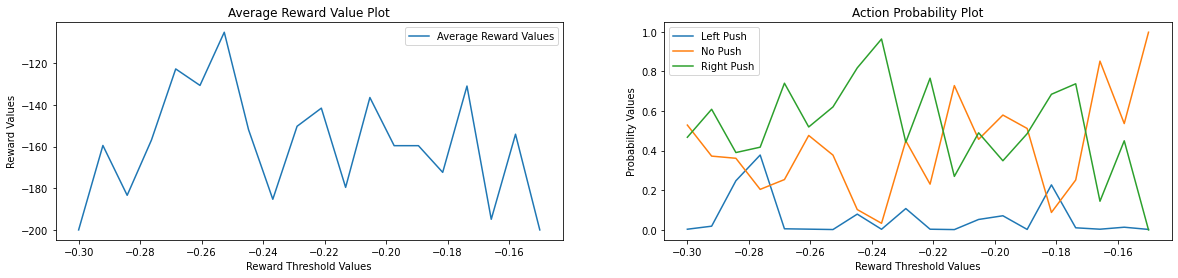

In [9]:
#Plots your results after model- training completion:
fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(reward_thresholds, average_reward_values, label='Average Reward Values')
ax2.plot(reward_thresholds, choices_one, label='Left Push')
ax2.plot(reward_thresholds, choices_zero, label='No Push')
ax2.plot(reward_thresholds, choices_two, label='Right Push')

ax1.set_xlabel('Reward Threshold Values')
ax1.set_ylabel('Reward Values')
ax1.set_title('Average Reward Value Plot')
ax1.legend()

ax2.set_xlabel('Reward Threshold Values')
ax2.set_ylabel('Probability Values')
ax2.set_title('Action Probability Plot')
ax2.legend()

plt.show()

In [10]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1366, 768))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1366x768x24', ':1005'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1366x768x24', ':1005'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [11]:
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from gym.wrappers import Monitor

In [12]:
def show_video():
    '''
    This function loads the data video inline into the colab notebook.
    By reading the video stored by the Monitor class.
    '''
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    '''
    This monitoring tool records the outputs from the output and saves it a
    mp4 file in the stated directory. If we don't change the video directory
    the videos will get stored in 'content/' directory.
    '''
    env = Monitor(env, './video', force=True)
    return env

In [13]:
wenv = wrap_env(env)
wenv.reset()
eval_agent(best_model, wenv, True)

show_video()

playing game no: 1
playing game no: 2
playing game no: 3
playing game no: 4
playing game no: 5
playing game no: 6
playing game no: 7
playing game no: 8
playing game no: 9
playing game no: 10
Average Score: -115.8
choice 1:0.0017271157167530224  choice 0:0.35751295336787564 choice 2:0.6407599309153713
